# Northwestern County 1st Time Home Buyer Analysis

Author: Armun Shakeri

# Overview

This project analyzes homes available in today's housing market and examines which of those homes would be appropriate for a first time home buyer. Also how price of a home is affected by independent values like sqft_living and price. 

# Business Problem

Recently property values have been increasing throughout the United States. For those wanting to buy their first home,  there are many factors that might raise the price of that home. This project analyzes these factors and explores whether they have a positive or negative affect on price. 

# Data Understanding

The following data is imported from KC housing data and shows different information about homes such as the date a home was sold, price, bedrooms...etc. For this project we will only use some of the data available, others will be removed.

In [1]:
# Import standard packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.diagnostic import het_white
%matplotlib inline

In [2]:
# Run code to explore the data
kc = pd.read_csv('data/kc_house_data.csv')

In [3]:
# this shows information regarding variables in kc dataframe 
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Below we drop values that are irrelevant towards first time hombe buyer analysis 
# We will remove id since we will be making general recommendations 
kc = kc.drop(['id', 'date', 'sqft_living15', 'sqft_lot15', 'yr_built', 'long', 'floors', 'condition', 
              'sqft_above', 'sqft_lot', 'waterfront', 'yr_renovated', 'view', 'zipcode'], axis=1)
kc.head()

,price,bedrooms,bathrooms,sqft_living,grade,sqft_basement,lat
0,221900.0,3,1.00,1180,7 Average,0.0,47.5112
1,538000.0,3,2.25,2570,7 Average,400.0,47.7210
2,180000.0,2,1.00,770,6 Low Average,0.0,47.7379
3,604000.0,4,3.00,1960,7 Average,910.0,47.5208
4,510000.0,3,2.00,1680,8 Good,0.0,47.6168


In [5]:
# Here we drop all Na values. 
kc=kc.dropna()

In [6]:
# First time home buyers will not be looking at homes over $1,000,000. Homes above that threshold will be removed. 
# Homes with bedrooms at or above 4, and greater than 2 floors will also be removed. 
kc = kc[kc.price<=1000000][kc.bedrooms<=10]
kc.head()

<ipython-input-6-4f7939aed66f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kc = kc[kc.price<=1000000][kc.bedrooms<=10]


,price,bedrooms,bathrooms,sqft_living,grade,sqft_basement,lat
0,221900.0,3,1.00,1180,7 Average,0.0,47.5112
1,538000.0,3,2.25,2570,7 Average,400.0,47.7210
2,180000.0,2,1.00,770,6 Low Average,0.0,47.7379
3,604000.0,4,3.00,1960,7 Average,910.0,47.5208
4,510000.0,3,2.00,1680,8 Good,0.0,47.6168


AttributeError: 'AxesSubplot' object has no attribute 'flatten'

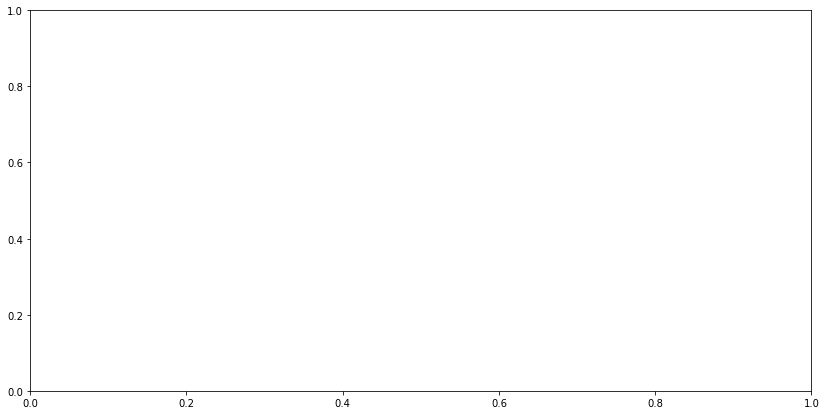

In [7]:
# plotting categorical values vs. price. This shows us all values within categoricals, which values have more
# items and how many categorival values there are. 

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,7), sharey=True)

categoricals = ['grade']

for col, ax in zip(categoricals, axes.flatten()):
    (kc.groupby(col)
       .mean()['price']            # take the mean of price for each group
       .sort_values()              # sort the groups in ascending order
       .plot
       .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)              # make the title the name of the column
    ax.set_ylabel('price')         # set y axis title as price
    
fig.tight_layout()

In [ ]:
# create dummy variables for categoricals (waterfront, condition and grade)

dummies = pd.get_dummies(kc[categoricals], prefix=categoricals, drop_first=True)     #create dummies and get rid of multicollinearity

kc = kc.drop(categoricals, axis=1)

kc = pd.concat([kc, dummies], axis=1)

kc.head()

In [ ]:
# Build correlation matrix
corr = kc.corr()
corr

In [ ]:
# remove spacing in grade column to help with baseline model 

kc.columns = [grade.replace(' ', '') for grade in kc.columns]

# Data Modeling

In [ ]:
# Here shows the different statistical values of the kc dataframe
kc.describe()

In [ ]:
# Build heatmap

# Set up figure and axis
fig, ax = plt.subplots(figsize=(25, 20))

sns.heatmap(kc.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            center=0);

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes");

# We see below that the highest to lowest correlated are as follows:
# 1) sqft_living x bathrooms
# 2) price x sqft_living
# 3) price x bathrooms

In [ ]:
# Build Baseline Model, incorporated majority of variables to help bring R^2 above .65
# Model displays low R-squared value, will need to add more values to raise R-squared
b = 'price~sqft_living'

model = ols(formula=b, data=kc).fit()
model.summary()

In [ ]:
# After adding lat and grade R-squared now has a value of .615

b = 'price~bedrooms+bathrooms+sqft_living+lat+grade_11Excellent+grade_12Luxury+grade_3Poor+grade_4Low+grade_5Fair+grade_6LowAverage+grade_7Average+grade_8Good'

model = ols(formula=b, data=kc).fit()
model.summary()

In [ ]:
# Visualize terms, specifically sqft_living

fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_living", fig=fig)
plt.show()

# the positive correlation in Y and Fitted vs. X graph shows that sqft_living and price are correlated. 
# this is heteroscedastic 

In [ ]:
# sqft_living seems fairly normally distributed, slight skew to the left

kc['sqft_living'].hist()

In [ ]:
# in order to scale this distribution we will need to perform a log transform 

kc['log_sqft_living'] = np.log(kc['sqft_living'])
kc['log_sqft_living'].hist()

In [ ]:
# price is more skewed to the left 

kc['price'].hist()

In [ ]:
# log transformation for price

kc['log_price'] = np.log(kc['price'])
kc['log_price'].hist()

In [ ]:
# final model

b2 = 'log_price~bedrooms+bathrooms+log_sqft_living+lat+grade_11Excellent+grade_12Luxury+grade_3Poor+grade_4Low+grade_5Fair+grade_6LowAverage+grade_7Average+grade_8Good'

model2 = ols(formula=b2, data=kc).fit()
model2.summary()

In [ ]:
residuals = model2.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

In [ ]:
# This histogram shows the normal distribution

residuals.hist()

In [ ]:
# Check Homoscedasticity

#define response variable
y = kc['log_price']

#define predictor variables
x = kc[['log_sqft_living', 'bathrooms']]

#add constant to predictor variables
x = sm.add_constant(x)

#fit regression model
model = sm.OLS(y, x).fit()

In [ ]:
# Perform White's test 

white_test = het_white(model2.resid, model2.model.exog)

# define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

# print results of White's test
print(dict(zip(labels, white_test)))

# p-value is extremely small which shows that the residuals are homoscedastic and therefore evenly distributed

In [ ]:
kc.info()

In [ ]:
# plot points to visualize Homoscedasticity, log_sqft_living

sns.regplot(x=kc['log_sqft_living'], y=kc['log_price'])

In [ ]:
kc.info()

In [ ]:
# plot points to visualize homoscedasticity, bathrooms

sns.lmplot(x=kc['bathrooms'], y=kc['log_price'])

# Evaluation 

# Conclusion